Best K: 3
Confusion matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


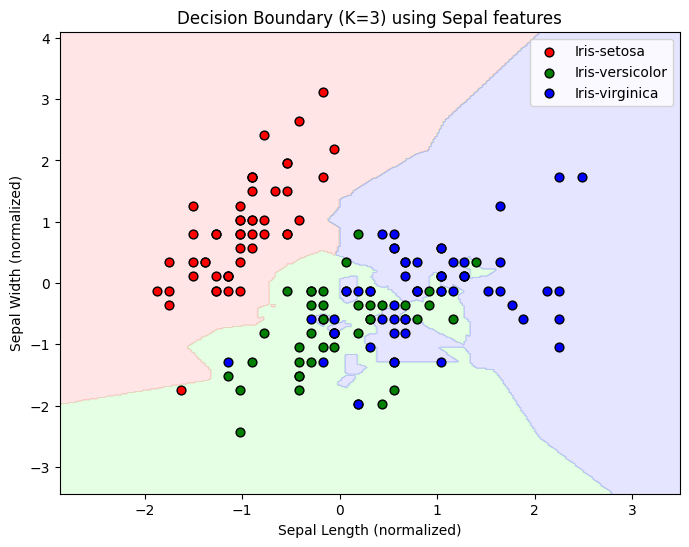

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap

# ---- load & preprocess (adjust path if needed) ----
df = pd.read_csv("Iris.csv")
if "Id" in df.columns:
    df = df.drop("Id", axis=1)

# force numeric features and handle any NaNs
X = df.drop("Species", axis=1).apply(pd.to_numeric, errors="coerce")
if X.isnull().any().any():
    X = X.fillna(X.mean())   # simple imputation for demo; optionally handle properly
y = df["Species"].astype(str)  # ensure string labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(float)

# ---- train/test split & find best K ----
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

accuracies = []
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, knn.predict(X_test)))

best_k = int(np.argmax(accuracies) + 1)
print("Best K:", best_k)

# ---- confusion matrix for best K ----
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=knn_best.classes_)
print("Confusion matrix:\n", cm)

# ---- decision boundary (use first two features for visualization) ----
X_vis = X_scaled[:, :2].astype(float)   # Sepal Length & Sepal Width (normalized)
y_np = y.to_numpy()

# Fit on the 2-feature subset
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y_np, test_size=0.3, random_state=42)
knn_vis = KNeighborsClassifier(n_neighbors=best_k)
knn_vis.fit(X_train_vis, y_train_vis)

# create mesh
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# predict on mesh -> these are string labels
Z_labels = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])

# MAP string labels -> integers for contourf
label_to_int = {label: idx for idx, label in enumerate(knn_vis.classes_)}
Z = np.vectorize(label_to_int.get)(Z_labels).astype(int).reshape(xx.shape)

# colormaps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['red', 'green', 'blue']

# plot regions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

# plot original points, one class at a time so colors match region codes
for idx, label in enumerate(knn_vis.classes_):
    mask = (y_np == label)
    plt.scatter(X_vis[mask, 0], X_vis[mask, 1],
                color=cmap_bold[idx], edgecolor='k', label=label, s=40)

plt.title(f"Decision Boundary (K={best_k}) using Sepal features")
plt.xlabel("Sepal Length (normalized)")
plt.ylabel("Sepal Width (normalized)")
plt.legend()
plt.show()

